# **Student ID: 2320993**

# ***Common Codes***

## Install Necessary Packages

In [ ]:
# Install necessary packages
!pip install transformers
!pip install vaderSentiment
!pip install gensim
!pip install wordcloud
!pip install seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 842.4 kB/s eta 0:00:00


## Imports and Mount Google Drive

This code block imports necessary libraries and mounts Google Drive to access datasets and save models.


In [ ]:
# Import necessary libraries
import os
import re
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from gensim.models import Word2Vec
from transformers import RobertaTokenizer, RobertaModel
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader, TensorDataset
from gensim.models import Word2Vec

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Mounted at /content/drive


## Set Paths and Initialize Seeds

This code block sets the paths for data files in Google Drive and initializes seeds for reproducibility.


In [ ]:
# Initialize all seeds for reproducibility
student_id = 2320993
np.random.seed(student_id)
torch.manual_seed(student_id)

# Define the relative path to your specific folder
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = './CE807-24-SU/Assignment/'
GOOGLE_DRIVE_PATH = os.path.join('/content/drive/My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

# Normalize the path to handle the relative reference
GOOGLE_DRIVE_PATH = os.path.normpath(GOOGLE_DRIVE_PATH)

# List files in the directory to ensure the path is correct
print('List files: ', os.listdir(GOOGLE_DRIVE_PATH))

DATA_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'data', '18')
train_file = os.path.join(DATA_PATH, 'train.csv')
val_file = os.path.join(DATA_PATH, 'valid.csv')
test_file = os.path.join(DATA_PATH, 'test.csv')

# Create directories for models if they don't exist
unsup_model_path = os.path.join(GOOGLE_DRIVE_PATH, 'model', str(student_id), 'Model_Unsup')
dis_model_path = os.path.join(GOOGLE_DRIVE_PATH, 'model', str(student_id), 'Model_Dis')
os.makedirs(unsup_model_path, exist_ok=True)
os.makedirs(dis_model_path, exist_ok=True)


print('Train file: ', train_file)
print('Validation file: ', val_file)
print('Test file: ', test_file)

List files:  ['data', 'code.ipynb']
Train file:  /content/drive/My Drive/CE807-24-SU/Assignment/data/18/train.csv
Validation file:  /content/drive/My Drive/CE807-24-SU/Assignment/data/18/valid.csv
Test file:  /content/drive/My Drive/CE807-24-SU/Assignment/data/18/test.csv


## Load and Preprocess Data

This function loads the dataset from CSV files and preprocesses the text data.
It includes steps such as removing empty values, expanding contractions, removing special characters,
and tokenizing and lemmatizing the text.

In [ ]:
def load_and_preprocess_data(train_file, val_file=None, test_file=None):
    # Load the datasets
    if test_file:
        df = pd.read_csv(test_file)
        print("Test data shape: ", df.shape)
    else:
        train_df = pd.read_csv(train_file)
        valid_df = pd.read_csv(val_file)
        print("Training data shape: ", train_df.shape)
        print("Validation data shape: ", valid_df.shape)

        # Check for empty values in the text column
        print("Number of empty values in training data text column: ", train_df['text'].isnull().sum())
        print("Number of empty values in validation data text column: ", valid_df['text'].isnull().sum())

        # Remove rows with empty values in the text column
        train_df = train_df.dropna(subset=['text'])
        valid_df = valid_df.dropna(subset=['text'])

        # Check for NaN values in the text column
        print("NaN values in 'text' column of training data: ", train_df['text'].isna().sum())
        print("NaN values in 'text' column of validation data: ", valid_df['text'].isna().sum())

        df = pd.concat([train_df, valid_df], ignore_index=True)

    # Ensure the text column is of string type
    df['text'] = df['text'].astype(str).str.lower()

    # Expand contractions
    contractions = {"can't": "cannot", "won't": "will not", "don't": "do not", "didn't": "did not"}
    df['text'] = df['text'].apply(lambda x: expand_contractions(x, contractions))

    # Preprocess text
    df['text'] = df['text'].apply(preprocess_text)

    # Tokenize and remove stop words
    stop_words = set(stopwords.words('english'))
    df['tokens'] = df['text'].apply(word_tokenize)
    df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    df['tokens_pos'] = df['tokens'].apply(nltk.pos_tag)
    df['tokens'] = df['tokens_pos'].apply(lambda x: [lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in x])

    # Remove short words and join tokens
    df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if len(word) >= 4])
    df['processed_text'] = df['tokens'].apply(lambda x: ' '.join(x))

    if test_file:
        return df
    else:
        train_df = df[df.index < len(train_df)].reset_index(drop=True)
        valid_df = df[df.index >= len(train_df)].reset_index(drop=True)
        return train_df, valid_df



def expand_contractions(text, contractions_dict):
    for contraction, expanded in contractions_dict.items():
        text = re.sub(r'\b{}\b'.format(contraction), expanded, text)
    return text

def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\d+', '', text)
    return text

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return 'a'  # Adjective
    elif tag.startswith('V'):
        return 'v'  # Verb
    elif tag.startswith('N'):
        return 'n'  # Noun
    elif tag.startswith('R'):
        return 'r'  # Adverb
    else:
        return 'n'  # Default to noun

# Load and preprocess data
train_df, valid_df = load_and_preprocess_data(train_file, val_file)


Training data shape:  (3681, 2)
Validation data shape:  (454, 2)
Number of empty values in training data text column:  1
Number of empty values in validation data text column:  0
NaN values in 'text' column of training data:  0
NaN values in 'text' column of validation data:  0


## Visualization Functions

This section contains functions for generating visualizations, such as word clouds and top words in positive and negative reviews.

### Word Cloud

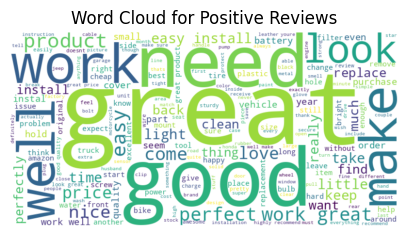

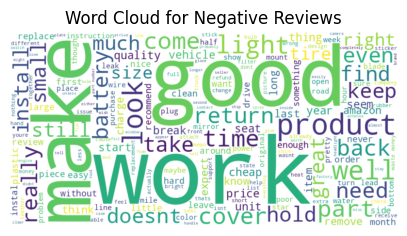

In [ ]:

def plot_positive_word_cloud(data):
    """
    Generates a word cloud for positive reviews.

    Args:
    data (DataFrame): DataFrame containing the processed text data.

    Returns:
    None
    """
    positive_reviews = ' '.join(data[data['sentiment'] == 'positive']['processed_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
    plt.figure(figsize=(5, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud for Positive Reviews')
    plt.show()

def plot_negative_word_cloud(data):
    """
    Generates a word cloud for negative reviews.

    Args:
    data (DataFrame): DataFrame containing the processed text data.

    Returns:
    None
    """
    negative_reviews = ' '.join(data[data['sentiment'] == 'negative']['processed_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)
    plt.figure(figsize=(5, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud for Negative Reviews')
    plt.show()

# Plot word clouds
plot_positive_word_cloud(train_df)
plot_negative_word_cloud(train_df)

### Top Words

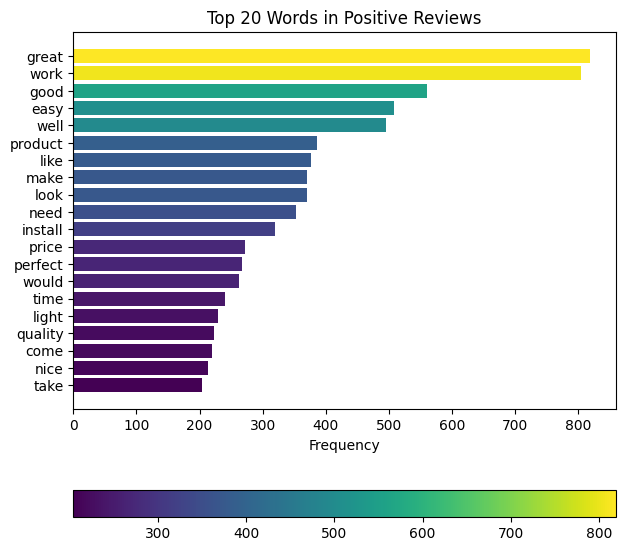

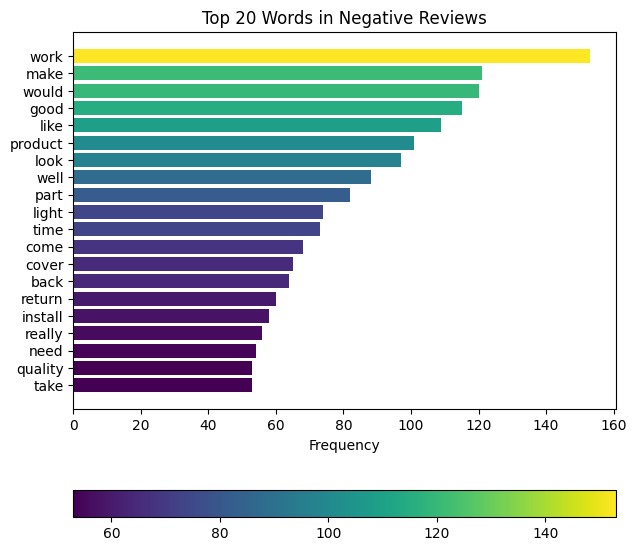

In [ ]:
def plot_top_words_positive_gradient(data):
    """
    Plots the top 20 words in positive reviews with gradient using matplotlib.

    Args:
    data (DataFrame): DataFrame containing the processed text data.

    Returns:
    None
    """
    top_words_positive = get_top_n_words(data[data['sentiment'] == 'positive']['processed_text'], 20)
    top_df_positive = pd.DataFrame(top_words_positive, columns=['Word', 'Frequency'])
    norm = plt.Normalize(top_df_positive['Frequency'].min(), top_df_positive['Frequency'].max())
    colors = plt.cm.viridis(norm(top_df_positive['Frequency']))
    fig, ax = plt.subplots(figsize=(7, 7))
    bars = ax.barh(top_df_positive['Word'], top_df_positive['Frequency'], color=colors)
    fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax, orientation='horizontal')
    ax.set_xlabel('Frequency')
    ax.set_title('Top 20 Words in Positive Reviews')
    ax.invert_yaxis()
    plt.show()

def plot_top_words_negative_gradient(data):
    """
    Plots the top 20 words in negative reviews with gradient using matplotlib.

    Args:
    data (DataFrame): DataFrame containing the processed text data.

    Returns:
    None
    """
    top_words_negative = get_top_n_words(data[data['sentiment'] == 'negative']['processed_text'], 20)
    top_df_negative = pd.DataFrame(top_words_negative, columns=['Word', 'Frequency'])
    norm = plt.Normalize(top_df_negative['Frequency'].min(), top_df_negative['Frequency'].max())
    colors = plt.cm.viridis(norm(top_df_negative['Frequency']))
    fig, ax = plt.subplots(figsize=(7, 7))
    bars = ax.barh(top_df_negative['Word'], top_df_negative['Frequency'], color=colors)
    fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax, orientation='horizontal')
    ax.set_xlabel('Frequency')
    ax.set_title('Top 20 Words in Negative Reviews')
    ax.invert_yaxis()
    plt.show()


def get_top_n_words(corpus, n=None):
    """
    Returns the top n words in a corpus.

    Args:
    corpus (list of str): List of strings containing the corpus.
    n (int, optional): Number of top words to return. Defaults to None.

    Returns:
    list of tuple: List of tuples containing the top n words and their frequencies.
    """
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Plot top words
plot_top_words_positive_gradient(train_df)
plot_top_words_negative_gradient(train_df)



### Text Length DIstribution

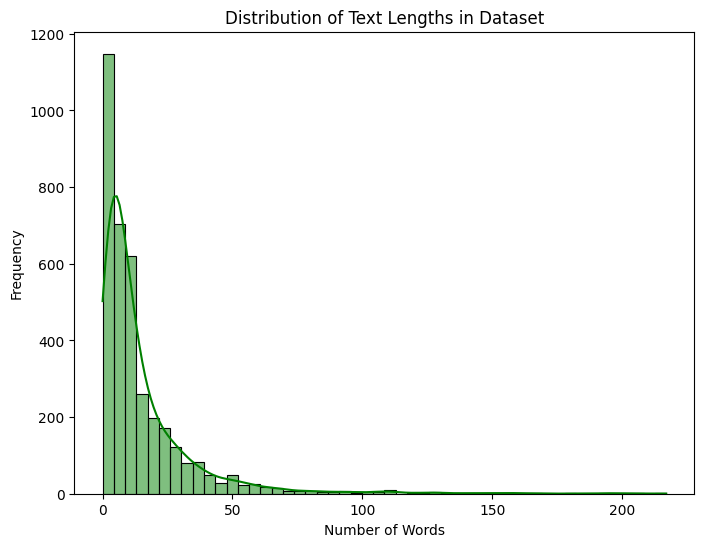

In [ ]:
def plot_text_length_distribution(data):
    """
    Plots the distribution of text lengths in the dataset.

    Args:
    data (DataFrame): DataFrame containing the processed text data.

    Returns:
    None
    """
    data['text_length'] = data['processed_text'].apply(lambda x: len(x.split()))
    plt.figure(figsize=(8, 6))
    sns.histplot(data['text_length'], bins=50, kde=True, color='green')
    plt.title('Distribution of Text Lengths in Dataset')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.show()

# Plot text length distribution
plot_text_length_distribution(train_df)

### Sentiment Distribution

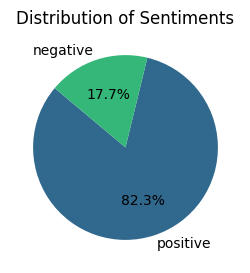

In [ ]:
def plot_sentiment_distribution(data):
    """
    Plots the distribution of sentiments in the dataset as a pie chart.

    Args:
    data (DataFrame): DataFrame containing the sentiment labels.

    Returns:
    None
    """
    sentiment_counts = data['sentiment'].value_counts()
    plt.figure(figsize=(3, 3))
    plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(sentiment_counts)))
    plt.title('Distribution of Sentiments')
    plt.show()


# Plot sentiment distribution
plot_sentiment_distribution(train_df)


### Target Encoding

In [ ]:
sentiment_mapping = {'positive': 1, 'negative': 0}
train_df['label'] = train_df['sentiment'].map(sentiment_mapping)
valid_df['label'] = valid_df['sentiment'].map(sentiment_mapping)


# ***Unsupervised Model***

This section contains functions for training and testing the unsupervised method.
It includes functions for training Word2Vec, Autoencoder, and K-Means, and for generating predictions.

## Unsupervised Method Functions

### Training Word2Vec Model for Word Embeddings



The train_word2vec function is used to train a Word2Vec model on a given set of tokenized sentences. This model learns vector representations (embeddings) of words from the input text. The function takes the following parameters:

sentences: A list of tokenized sentences (each sentence is a list of words).
vector_size: The dimensionality of the word vectors. Default is 100.
window: The maximum distance between the current and predicted word within a sentence. Default is 5.
min_count: The minimum number of occurrences a word must have to be included in the model. Default is 1.
workers: The number of worker threads to train the model. Default is 4.

We use the train_word2vec function in our code to convert text data into numerical vector representations. These embeddings are essential for:

Feature Extraction: Word embeddings serve as input features for the autoencoder and clustering models. They allow us to represent text data in a numerical format that machine learning algorithms can process.
Semantic Understanding: Word2Vec embeddings capture semantic meanings and relationships between words. Words with similar meanings will have similar vector representations, which helps the models understand the context and nuances of the text data.
Dimensionality Reduction: By representing words as vectors of fixed dimensionality, we can reduce the complexity of the text data and make it suitable for machine learning algorithms.

In [ ]:
def train_word2vec(sentences, vector_size=100, window=5, min_count=1, workers=4):
    """
    Trains a Word2Vec model on the provided sentences.

    Args:
    sentences (list of list of str): Tokenized sentences.
    vector_size (int): Dimensionality of the word vectors. Default is 100.
    window (int): Maximum distance between the current and predicted word within a sentence. Default is 5.
    min_count (int): Ignores all words with total frequency lower than this. Default is 1.
    workers (int): Number of worker threads to train the model. Default is 4.

    Returns:
    Word2Vec: Trained Word2Vec model.
    """
    model = Word2Vec(sentences=sentences, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    return model

### Computing Average Word2Vec Embedding

The get_avg_word2vec function computes the average Word2Vec embedding for a given sentence. It takes the following parameters:

sentence: A tokenized sentence (list of words).
model: A trained Word2Vec model.
The function returns a NumPy array representing the average Word2Vec embedding for the input sentence. If none of the words in the sentence are present in the Word2Vec model's vocabulary, the function returns a zero vector of the same dimensionality as the word vectors in the model.

We use the get_avg_word2vec function to obtain a fixed-size vector representation for entire sentences based on their word embeddings. This is important for several reasons:

Sentence Representation: By averaging the embeddings of individual words, we can represent the entire sentence as a single vector. This is necessary because most machine learning models require fixed-size input features.
Dimensionality Reduction: Averaging the word vectors reduces the complexity of the data while preserving important semantic information, making it easier to process and analyze.
Uniform Input for Models: This function ensures that every sentence, regardless of its length, is represented by a vector of the same dimensionality. This uniformity is crucial for feeding the data into models like autoencoders and clustering algorithms.

In [ ]:
def get_avg_word2vec(sentence, model):
    """
    Computes the average Word2Vec embedding for a given sentence.

    Args:
    sentence (list of str): Tokenized sentence.
    model (Word2Vec): Trained Word2Vec model.

    Returns:
    np.array: Average Word2Vec embedding.
    """
    vec = np.zeros(model.vector_size)
    count = 0
    for word in sentence:
        if word in model.wv:
            vec += model.wv[word]
            count += 1
    if count != 0:
        vec /= count
    return vec

### Embeddings

We use the get_embedding function to standardize the shape of sentence embeddings, ensuring consistency and reliability when processing data for machine learning models. This function serves the following purposes:

Shape Consistency: Ensures that all sentence embeddings have the same dimensionality as the word vectors in the Word2Vec model. This is important because machine learning models expect input features to have a consistent shape.
Error Handling: Returns a zero vector if the computed embedding does not match the expected shape, preventing potential errors or issues when feeding the data into models.
Integration with Models: By standardizing the shape of the embeddings, this function facilitates smooth integration with downstream models such as autoencoders and clustering algorithms, which require fixed-size input features.

In [ ]:
def get_embedding(sentence, model):
    """
    Ensures each embedding has the correct shape.

    Args:
    sentence (list of str): Tokenized sentence.
    model (Word2Vec): Trained Word2Vec model.

    Returns:
    np.array: Correctly shaped embedding.
    """
    embedding = get_avg_word2vec(sentence, model)
    if embedding.shape[0] != model.vector_size:
        return np.zeros(model.vector_size)
    return embedding

### Autoencoder Neural Network

The Autoencoder class defines a neural network designed for dimensionality reduction. It consists of two main components:

Encoder: Compresses the input data into a lower-dimensional representation.
Decoder: Reconstructs the original data from the lower-dimensional representation.
The class includes:

An encoder attribute, which is a sequential neural network with two linear layers and ReLU activation functions.
A decoder attribute, which is also a sequential neural network with two linear layers, ReLU activation functions, and a Sigmoid activation function in the final layer.
The forward method defines how data passes through the encoder and then the decoder, returning both the encoded and decoded outputs.



The Autoencoder class is used for the following purposes:

Dimensionality Reduction: Compresses high-dimensional data into a lower-dimensional space, making it more manageable and suitable for further processing or analysis.
Feature Learning: Learns meaningful representations of the input data, which can be used in various machine learning tasks such as clustering, classification, or anomaly detection.
Noise Reduction: Can be used to denoise data by training the autoencoder to reconstruct clean data from noisy inputs.
Data Reconstruction: The decoder can reconstruct the original input data from the encoded representation, useful in applications where data recovery is important.

In [ ]:
class Autoencoder(nn.Module):
    """
    Autoencoder neural network for dimensionality reduction.

    Attributes:
    encoder (nn.Sequential): Encoder network.
    decoder (nn.Sequential): Decoder network.
    """
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

### Training an Autoencoder

The purpose of this function is to train an autoencoder model effectively while preventing overfitting. Key reasons for its implementation are:

Dimensionality Reduction: The autoencoder learns a compressed representation of the input data.
Feature Learning: It helps in extracting meaningful features from the input data, which can be used in other machine learning tasks.
Early Stopping: This technique monitors the validation loss and stops training when there is no improvement for a specified number of epochs (patience). This helps in avoiding overfitting and saves computational resources.
Training and Validation Loss Monitoring: The function prints the training and validation loss for each epoch, providing insights into the model's learning process.

In [ ]:
def train_autoencoder(train_embeddings, valid_embeddings, encoding_dim=32, num_epochs=100, batch_size=64, learning_rate=0.001, patience=5):
    """
    Trains an Autoencoder on the provided embeddings with early stopping.

    Args:
    train_embeddings (np.array): Training embeddings.
    valid_embeddings (np.array): Validation embeddings.
    encoding_dim (int): Dimensionality of the encoded space. Default is 32.
    num_epochs (int): Number of epochs to train. Default is 100.
    batch_size (int): Batch size. Default is 64.
    learning_rate (float): Learning rate. Default is 0.001.
    patience (int): Number of epochs to wait for improvement before stopping early. Default is 5.

    Returns:
    Autoencoder: Trained Autoencoder model.
    """
    input_dim = train_embeddings.shape[1]
    model = Autoencoder(input_dim, encoding_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_embeddings_tensor = torch.tensor(train_embeddings, dtype=torch.float32)
    valid_embeddings_tensor = torch.tensor(valid_embeddings, dtype=torch.float32)
    train_loader = torch.utils.data.DataLoader(train_embeddings_tensor, batch_size=batch_size, shuffle=True)

    best_valid_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        train_loss = 0.0
        for data in train_loader:
            # Forward pass
            encoded, decoded = model(data)
            loss = criterion(decoded, data)
            train_loss += loss.item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        valid_loss = criterion(model(valid_embeddings_tensor)[1], valid_embeddings_tensor).item()

        if epoch == 0 or (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Valid Loss: {valid_loss:.4f}')

        # Early stopping
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping due to no improvement in validation loss.")
                break

    return model


### K-Means Clustering

The purpose of this function is to cluster the encoded embeddings into distinct groups. Key reasons for its implementation are:

Cluster Identification: K-Means clustering helps in identifying patterns or clusters in the encoded embeddings.
Sentiment Analysis: By clustering the embeddings, we can infer sentiment or other latent features within the data.
Unsupervised Learning: K-Means is an unsupervised learning algorithm, which is suitable for tasks where labeled data is not available.

In [ ]:
def train_kmeans(encoded_embeddings, num_clusters=2):
    """
    Applies K-Means clustering to the encoded embeddings.

    Args:
    encoded_embeddings (np.array): Encoded embeddings.
    num_clusters (int): Number of clusters.

    Returns:
    KMeans: Trained KMeans model.
    """
    kmeans_model = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    kmeans_model.fit(encoded_embeddings)
    return kmeans_model

### Computing Sentiment

The get_cluster_sentiment function computes the average sentiment score for a given cluster using the VADER sentiment analyzer. The function parameters include:

The purpose of this function is to determine the overall sentiment of a group of texts that belong to the same cluster. This is important for:

Sentiment Analysis: Identifying the sentiment of clusters to infer whether the cluster represents positive, negative, or neutral sentiment.
Cluster Interpretation: Helps in understanding the nature of each cluster by analyzing the sentiment of its texts.
Unsupervised Learning: In the context of unsupervised learning, it provides a way to label clusters based on sentiment, aiding in further analysis and model interpretation.

In [ ]:
def get_cluster_sentiment(cluster_id, data, analyzer):
    """
    Computes the average sentiment for a cluster using VADER sentiment analyzer.

    Args:
    cluster_id (int): Cluster ID.
    data (DataFrame): DataFrame containing processed text data.
    analyzer (SentimentIntensityAnalyzer): VADER sentiment analyzer.

    Returns:
    float: Average sentiment score for the cluster.
    """
    cluster_texts = data[data['cluster'] == cluster_id]['processed_text'].tolist()
    sentiment_scores = [analyzer.polarity_scores(text)['compound'] for text in cluster_texts]
    return np.mean(sentiment_scores)

### Visualize latent space quality using t-SNE

The plot_tsne function visualizes the high-dimensional encoded embeddings in a 2-dimensional space using t-SNE (t-Distributed Stochastic Neighbor Embedding). This function takes the encoded embeddings and their corresponding labels, performs t-SNE dimensionality reduction, and creates a scatter plot to visualize the clusters.

In [ ]:
def plot_tsne(encoded_embeddings, labels, title):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(encoded_embeddings)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=labels, palette='viridis')
    plt.title(title)
    plt.xlabel('TSNE-1')
    plt.ylabel('TSNE-2')
    plt.legend()
    plt.show()

## Training Unsupervised Method Code

This function trains the unsupervised model (Word2Vec + Autoencoder + K-Means) and saves the models.


Shape of train embeddings: (3680, 100)
Shape of valid embeddings: (454, 100)
Epoch [1/100], Train Loss: 0.1817, Valid Loss: 0.0621
Epoch [5/100], Train Loss: 0.0517, Valid Loss: 0.0517
Epoch [10/100], Train Loss: 0.0515, Valid Loss: 0.0514
Epoch [15/100], Train Loss: 0.0514, Valid Loss: 0.0514
Epoch [20/100], Train Loss: 0.0514, Valid Loss: 0.0514
Epoch [25/100], Train Loss: 0.0513, Valid Loss: 0.0514
Epoch [30/100], Train Loss: 0.0514, Valid Loss: 0.0514
Epoch [35/100], Train Loss: 0.0514, Valid Loss: 0.0514
Epoch [40/100], Train Loss: 0.0513, Valid Loss: 0.0514
Epoch [45/100], Train Loss: 0.0514, Valid Loss: 0.0514
Epoch [50/100], Train Loss: 0.0513, Valid Loss: 0.0514
Epoch [55/100], Train Loss: 0.0513, Valid Loss: 0.0514
Epoch [60/100], Train Loss: 0.0514, Valid Loss: 0.0513
Epoch [65/100], Train Loss: 0.0513, Valid Loss: 0.0513
Epoch [70/100], Train Loss: 0.0513, Valid Loss: 0.0513
Epoch [75/100], Train Loss: 0.0514, Valid Loss: 0.0513
Epoch [80/100], Train Loss: 0.0513, Valid Los

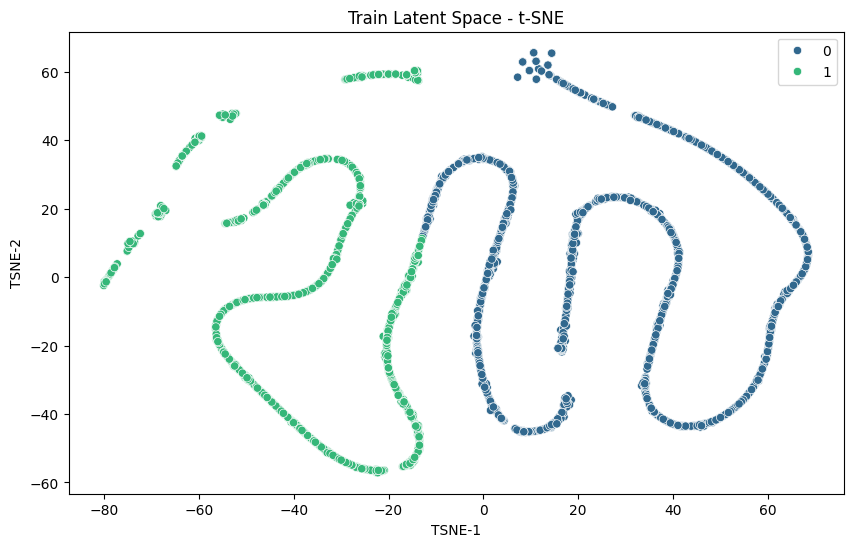

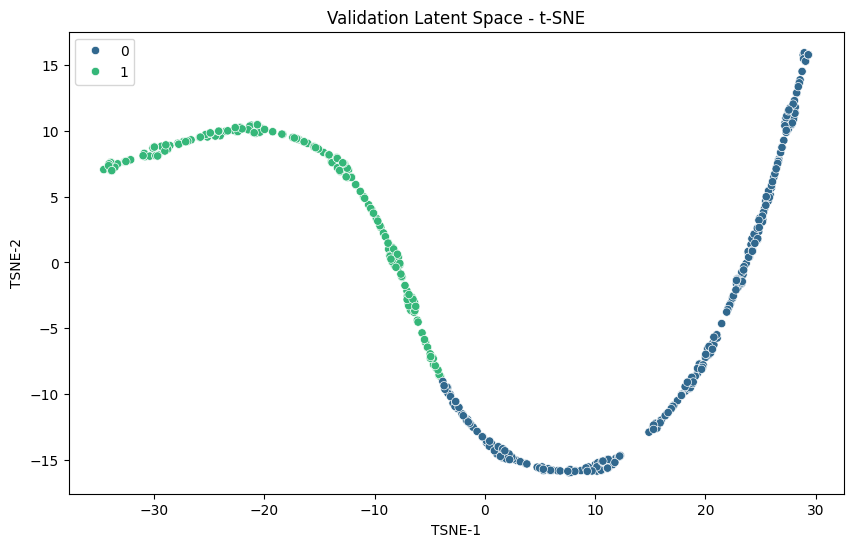

In [ ]:
def train_unsup():
    unsup_model_path = os.path.join(GOOGLE_DRIVE_PATH, 'model', str(student_id), 'Model_Unsup')
    os.makedirs(unsup_model_path, exist_ok=True)

    # Prepare the data for Word2Vec
    train_sentences = train_df['tokens'].tolist()
    valid_sentences = valid_df['tokens'].tolist()
    all_sentences = train_sentences + valid_sentences

    # Train Word2Vec model
    word2vec_model = train_word2vec(all_sentences)

    # Get embeddings for train and validation sets
    train_embeddings = train_df['tokens'].apply(lambda x: get_embedding(x, word2vec_model))
    valid_embeddings = valid_df['tokens'].apply(lambda x: get_embedding(x, word2vec_model))

    # Convert embeddings to numpy arrays
    train_embeddings = np.array(list(train_embeddings))
    valid_embeddings = np.array(list(valid_embeddings))

    print("Shape of train embeddings:", train_embeddings.shape)
    print("Shape of valid embeddings:", valid_embeddings.shape)

    # Train Autoencoder
    autoencoder_model = train_autoencoder(train_embeddings, valid_embeddings)

    # Encode the embeddings
    with torch.no_grad():
        train_encoded = autoencoder_model.encoder(torch.tensor(train_embeddings, dtype=torch.float32)).numpy()
        valid_encoded = autoencoder_model.encoder(torch.tensor(valid_embeddings, dtype=torch.float32)).numpy()

    # Apply K-Means clustering
    kmeans_model = train_kmeans(np.vstack((train_encoded, valid_encoded)), num_clusters=2)

    # Assign clusters to train and validation sets
    train_clusters = kmeans_model.predict(train_encoded)
    valid_clusters = kmeans_model.predict(valid_encoded)

    train_df['cluster'] = train_clusters
    valid_df['cluster'] = valid_clusters

    # Initialize VADER sentiment analyzer
    analyzer = SentimentIntensityAnalyzer()

    # Get sentiment scores for each cluster
    cluster_sentiments = {cluster_id: get_cluster_sentiment(cluster_id, train_df, analyzer) for cluster_id in range(kmeans_model.n_clusters)}

    # Assign sentiment to each review based on the cluster
    train_df['predicted_sentiment'] = train_df['cluster'].map(cluster_sentiments)
    train_df['predicted_label'] = train_df['predicted_sentiment'].apply(lambda x: 1 if x >= 0 else 0)

    valid_df['predicted_sentiment'] = valid_df['cluster'].map(cluster_sentiments)
    valid_df['predicted_label'] = valid_df['predicted_sentiment'].apply(lambda x: 1 if x >= 0 else 0)

    # Ensure 'label' column is present
    sentiment_mapping = {'positive': 1, 'negative': 0}
    train_df['label'] = train_df['sentiment'].map(sentiment_mapping)
    valid_df['label'] = valid_df['sentiment'].map(sentiment_mapping)

    # Evaluate clustering performance
    silhouette_avg_train = silhouette_score(train_encoded, train_clusters)
    silhouette_avg_valid = silhouette_score(valid_encoded, valid_clusters)
    db_score_train = davies_bouldin_score(train_encoded, train_clusters)
    db_score_valid = davies_bouldin_score(valid_encoded, valid_clusters)

    print()
    print(f"Train Silhouette Score: {silhouette_avg_train}")
    print(f"Validation Silhouette Score: {silhouette_avg_valid}")
    print(f"Train Davies-Bouldin Score: {db_score_train}")
    print(f"Validation Davies-Bouldin Score: {db_score_valid}")

    # Visualize latent space using t-SNE
    print()
    plot_tsne(train_encoded, train_clusters, "Train Latent Space - t-SNE")
    print()
    plot_tsne(valid_encoded, valid_clusters, "Validation Latent Space - t-SNE")

    # Save models
    word2vec_model.save(os.path.join(unsup_model_path, 'word2vec.model'))
    torch.save(autoencoder_model.state_dict(), os.path.join(unsup_model_path, 'autoencoder.pth'))
    with open(os.path.join(unsup_model_path, 'kmeans.pkl'), 'wb') as f:
        pickle.dump(kmeans_model, f)

train_unsup()


1. Reconstruction Loss: Measures how well the autoencoder can reconstruct the input data.
2. Silhouette Score: Evaluates how well the data points are clustered.
3. Davies-Bouldin Index: Measures the average similarity ratio of each cluster with the cluster most similar to it.

## Testing Method Unsupervised Code

This function tests the unsupervised model on the test set and saves the predictions.


In [ ]:
def test_unsup():
    np.random.seed(student_id)
    torch.manual_seed(student_id)
    unsup_model_path = os.path.join(GOOGLE_DRIVE_PATH, 'model', str(student_id), 'Model_Unsup')

    # Load original test data
    test_df = pd.read_csv(test_file)

    # Load and preprocess test data without altering the original DataFrame structure
    processed_test_df = load_and_preprocess_data(None, None, test_file=test_file)

    # Load models
    word2vec_model = Word2Vec.load(os.path.join(unsup_model_path, 'word2vec.model'))
    autoencoder_model = Autoencoder(input_dim=100, encoding_dim=32)
    autoencoder_model.load_state_dict(torch.load(os.path.join(unsup_model_path, 'autoencoder.pth')))
    with open(os.path.join(unsup_model_path, 'kmeans.pkl'), 'rb') as f:
        kmeans_model = pickle.load(f)

    # Generate Word2Vec embeddings for the test data
    test_embeddings = processed_test_df['tokens'].apply(lambda x: get_embedding(x, word2vec_model))
    test_embeddings = np.array(list(test_embeddings))

    # Convert to PyTorch tensor
    test_embeddings_tensor = torch.tensor(test_embeddings, dtype=torch.float32)

    # Encode using the autoencoder
    with torch.no_grad():
        test_encoded = autoencoder_model.encoder(test_embeddings_tensor).numpy()

    # Predict clusters using K-Means
    test_clusters = kmeans_model.predict(test_encoded)
    processed_test_df['cluster'] = test_clusters

    # Predict sentiment based on clusters
    analyzer = SentimentIntensityAnalyzer()
    cluster_sentiments = {cluster_id: get_cluster_sentiment(cluster_id, train_df, analyzer) for cluster_id in range(kmeans_model.n_clusters)}
    processed_test_df['predicted_sentiment'] = processed_test_df['cluster'].map(cluster_sentiments)
    processed_test_df['out_label_model_unsup'] = processed_test_df['predicted_sentiment'].apply(lambda x: 1 if x >= 0 else 0)

    # Update only the out_label_model_unsup column in the original test DataFrame
    test_df['out_label_model_unsup'] = processed_test_df['out_label_model_unsup'].map({1: 'positive', 0: 'negative'})

    # Save the updated test file
    test_df.to_csv(test_file, index=False)

    print(f"Test output saved to {test_file}")

test_unsup()


Test data shape:  (409, 3)
Test output saved to /content/drive/My Drive/CE807-24-SU/Assignment/data/18/test.csv


# ***Discriminative model***

Logistic Regression is chosen for this task due to its simplicity, efficiency, and effectiveness in binary classification problems. It is a well-established algorithm that performs well with high-dimensional data such as embeddings. Logistic Regression's probabilistic interpretation is also beneficial for understanding model confidence in predictions.

## Discriminative Method Functions

This section contains functions for training and testing the discriminative method.
It includes functions for tokenizing text, getting embeddings using RoBERTa, and training Logistic Regression.

RoBERTa embeddings capture rich semantic information from text. Using these embeddings helps in leveraging the power of pre-trained models to achieve better performance in downstream tasks like sentiment classification.


In [ ]:
def get_embeddings(text, tokenizer, model):
    """
    Tokenizes and gets embeddings using a pre-trained RoBERTa model.

    Args:
    text (str): Input text.
    tokenizer (RobertaTokenizer): Pre-trained RoBERTa tokenizer.
    model (RobertaModel): Pre-trained RoBERTa model.

    Returns:
    np.array: Embedding vector for the input text.
    """
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embeddings

Logistic Regression is a simple yet effective classifier for binary classification tasks. It is computationally efficient and works well with high-dimensional data like embeddings. Evaluating the model with a classification report, confusion matrix, and ROC curve helps in understanding its performance on the validation set.

In [ ]:
def train_logistic_regression(X_train, y_train, X_valid, y_valid):
    """
    Trains a Logistic Regression model on the provided embeddings.

    Args:
    X_train (np.array): Training embeddings.
    y_train (np.array): Training labels.
    X_valid (np.array): Validation embeddings.
    y_valid (np.array): Validation labels.

    Returns:
    LogisticRegression: Trained Logistic Regression model.
    float: Validation accuracy.
    """
    log_reg = LogisticRegression(max_iter=1000, random_state=42)
    log_reg.fit(X_train, y_train)
    log_reg_labels = log_reg.predict(X_valid)
    log_reg_accuracy = accuracy_score(y_valid, log_reg_labels)

    # Print classification report
    print()
    print("Classification Report:")
    print(classification_report(y_valid, log_reg_labels))

    # Plot confusion matrix
    cm = confusion_matrix(y_valid, log_reg_labels)
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Plot ROC curve
    y_valid_proba = log_reg.predict_proba(X_valid)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_valid, y_valid_proba)
    roc_auc = roc_auc_score(y_valid, y_valid_proba)

    print()
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    return log_reg, log_reg_accuracy

## Training Discriminative Method Code

This function trains the discriminative model (RoBERTa + Logistic Regression) and saves the models.


This function integrates all the steps needed to train a discriminative model for sentiment classification. By using RoBERTa embeddings, it ensures that the model has access to high-quality, pre-trained features. Logistic Regression is chosen for its simplicity and effectiveness in binary classification tasks.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.45      0.57        80
           1       0.89      0.97      0.93       374

    accuracy                           0.88       454
   macro avg       0.84      0.71      0.75       454
weighted avg       0.87      0.88      0.87       454



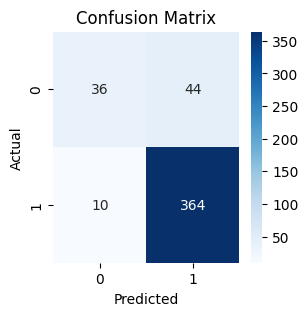

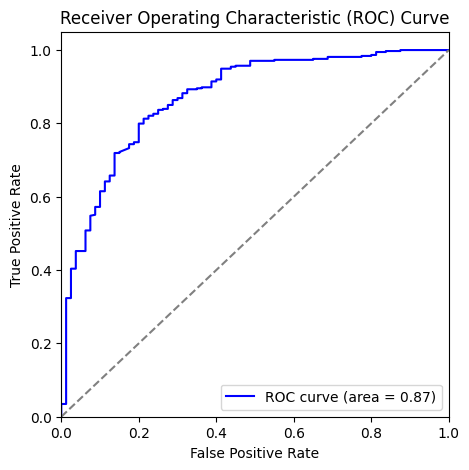


Logistic Regression Cross-Validation Scores: 0.8810572687224669

Logistic Regression Mean Cross-Validation Accuracy: 0.8810572687224669


In [ ]:
def train_dis():
    np.random.seed(student_id)
    torch.manual_seed(student_id)
    dis_model_path = os.path.join(GOOGLE_DRIVE_PATH, 'model', str(student_id), 'Model_Dis')
    os.makedirs(dis_model_path, exist_ok=True)

    # Load pre-trained RoBERTa model and tokenizer
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    model = RobertaModel.from_pretrained('roberta-base')

    # Get embeddings for train and validation sets
    train_df['embeddings'] = train_df['processed_text'].apply(lambda x: get_embeddings(x, tokenizer, model))
    valid_df['embeddings'] = valid_df['processed_text'].apply(lambda x: get_embeddings(x, tokenizer, model))
    X_train = np.array(train_df['embeddings'].tolist())
    X_valid = np.array(valid_df['embeddings'].tolist())

    y_train = train_df['label']
    y_valid = valid_df['label']

    # Train and evaluate Logistic Regression model
    log_reg_model, log_reg_valid_scores = train_logistic_regression(X_train, y_train, X_valid, y_valid)

    print()
    print(f"Logistic Regression Cross-Validation Scores: {log_reg_valid_scores}")
    print()
    print(f"Logistic Regression Mean Cross-Validation Accuracy: {log_reg_valid_scores.mean()}")

    # Fit the model on the entire training set
    log_reg_model.fit(X_train, y_train)

    # Save the Logistic Regression model
    with open(os.path.join(dis_model_path, 'log_reg_model.pkl'), 'wb') as f:
        pickle.dump(log_reg_model, f)

train_dis()

1. Accuracy: Proportion of correctly classified instances.
2. Precision, Recall, F1-Score: Evaluate the balance between precision and recall.
3. ROC-AUC: Measures the trade-off between true positive rate and false positive rate.

## Testing Discriminative Method Code

After training the model, it is essential to evaluate its performance on unseen test data. This function automates the process of loading the model, generating predictions, and saving the results. It ensures that the test data is processed in the same way as the training data, maintaining consistency.

In [ ]:
def test_dis():
    np.random.seed(student_id)
    torch.manual_seed(student_id)
    dis_model_path = os.path.join(GOOGLE_DRIVE_PATH, 'model', str(student_id), 'Model_Dis')

    # Load pre-trained RoBERTa model and tokenizer
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    model = RobertaModel.from_pretrained('roberta-base')

    # Load and preprocess test data
    test_df = load_and_preprocess_data(None, None, test_file=test_file)

    # Load the Logistic Regression model
    with open(os.path.join(dis_model_path, 'log_reg_model.pkl'), 'rb') as f:
        log_reg_model = pickle.load(f)

    # Get embeddings for the test data
    test_df['embeddings'] = test_df['processed_text'].apply(lambda x: get_embeddings(x, tokenizer, model))
    X_test = np.array(test_df['embeddings'].tolist())

    # Predict sentiments using the Logistic Regression model
    test_df['out_label_model_dis'] = log_reg_model.predict(X_test)

    # Map labels to "positive" and "negative"
    test_df['out_label_model_dis'] = test_df['out_label_model_dis'].map({1: 'positive', 0: 'negative'})

    # Drop unnecessary columns
    columns_to_drop = ['tokens', 'tokens_pos', 'processed_text', 'embeddings']
    test_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

    # Save the DataFrame with the updated column
    test_df.to_csv(test_file, index=False)

    print(f"Test output saved to {test_file}")

test_dis()


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test data shape:  (409, 3)
Test output saved to /content/drive/My Drive/CE807-24-SU/Assignment/data/18/test.csv


# ***Generative Model***

## Prepare the Data

In [ ]:
def prepare_data(df, word2vec_model):
    embeddings = df['tokens'].apply(lambda x: get_embedding(x, word2vec_model))
    embeddings = np.array(list(embeddings))
    return torch.tensor(embeddings, dtype=torch.float32)

## Build the VAE

VAEs are generative models that learn to encode input data into a latent space and then decode it back to the original space. This helps in tasks like dimensionality reduction, generating new data, and understanding the data distribution.


The reconstruction loss measures how well the VAE can reconstruct the input data, while the KLD measures the difference between the learned latent distribution and a prior distribution. Combining these ensures that the VAE learns a meaningful latent space.


In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2)  # Output both mean and log variance
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mean, log_var = h.chunk(2, dim=-1)
        return mean, log_var

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterize(mean, log_var)
        x_recon = self.decode(z)
        return x_recon, mean, log_var

def loss_function(recon_x, x, mean, log_var):
    recon_loss = nn.MSELoss()(recon_x, x)
    kld = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return recon_loss + kld


## Train the VAE

Training the VAE involves minimizing the loss function to learn good representations. Early stopping helps prevent overfitting by stopping training when the validation loss doesn't improve.

In [ ]:
def train_autoencoder(train_loader, valid_embeddings_tensor, encoding_dim=32, num_epochs=100, batch_size=64, learning_rate=0.001, patience=5):
    input_dim = train_loader.dataset.tensors[0].shape[1]
    model = VAE(input_dim, hidden_dim=128, latent_dim=encoding_dim)
    criterion = loss_function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_valid_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for data in train_loader:
            data = data[0]
            optimizer.zero_grad()
            recon_data, mean, log_var = model(data)
            loss = criterion(recon_data, data, mean, log_var)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        train_loss /= len(train_loader)

        model.eval()
        with torch.no_grad():
            valid_recon_data, valid_mean, valid_log_var = model(valid_embeddings_tensor)
            valid_loss = criterion(valid_recon_data, valid_embeddings_tensor, valid_mean, valid_log_var).item()

        if epoch == 0 or (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping due to no improvement in validation loss.")
                break

    return model


## Evaluate the VAE

Evaluating the model helps understand how well it has learned to encode and decode the data. It provides insights into the quality of the learned representations and the generative capabilities of the VAE.

t-SNE is a technique for visualizing high-dimensional data in a 2D space. It helps to understand how well the VAE has clustered similar data points in the latent space.

In [ ]:
def evaluate_vae(model, data_tensor, title):
    model.eval()
    with torch.no_grad():
        recon_data, mean, log_var = model(data_tensor)
        recon_loss = nn.MSELoss()(recon_data, data_tensor).item()
        kld = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp()).item()
        total_loss = recon_loss + kld

    print(f'{title} Reconstruction Loss: {recon_loss:.4f}')
    print(f'{title} KLD: {kld:.4f}')
    print(f'{title} Total Loss: {total_loss:.4f}')

    return total_loss

def plot_tsne(encoded_embeddings, labels, title):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(encoded_embeddings)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=labels, palette='viridis')
    plt.title(title)
    plt.xlabel('TSNE-1')
    plt.ylabel('TSNE-2')
    plt.legend()
    plt.show()


## Generate New Data

One of the key features of generative models like VAEs is the ability to generate new, plausible data points. This function demonstrates the generative capabilities of the VAE by creating new text samples.


In [ ]:
def generate_new_data(model, latent_dim, word2vec_model, num_samples=10):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim)
        generated_embeddings = model.decode(z).numpy()

    new_texts = []
    for embedding in generated_embeddings:
        similar_words = word2vec_model.wv.most_similar(positive=[embedding], topn=10)
        new_text = ' '.join([word for word, _ in similar_words])
        new_texts.append(new_text)

    print("Generated Texts:")
    for text in new_texts:
        print(text)


## Train Model

Epoch [1/25], Train Loss: 0.8828, Valid Loss: 0.2780
Epoch [5/25], Train Loss: 0.0605, Valid Loss: 0.0689
Epoch [10/25], Train Loss: 0.0584, Valid Loss: 0.0662
Epoch [15/25], Train Loss: 0.0579, Valid Loss: 0.0650
Epoch [20/25], Train Loss: 0.0576, Valid Loss: 0.0639
Epoch [25/25], Train Loss: 0.0575, Valid Loss: 0.0640
Train Reconstruction Loss: 0.0568
Train KLD: 0.0533
Train Total Loss: 0.1101
Validation Reconstruction Loss: 0.0570
Validation KLD: 0.0071
Validation Total Loss: 0.0641



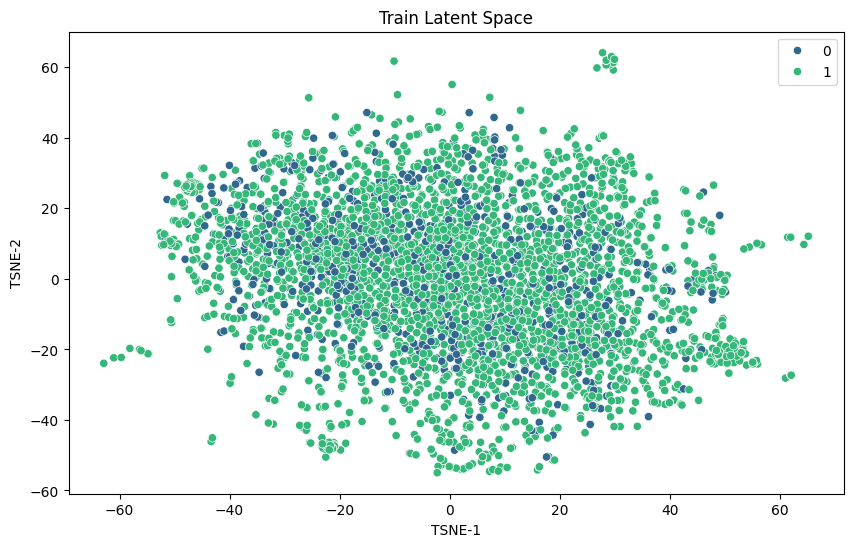

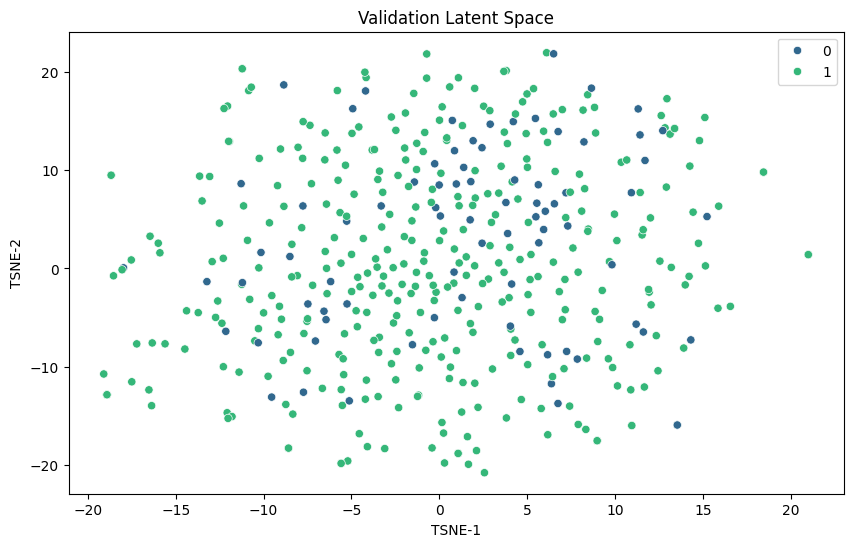

Generated Texts:
kelvin meguiars compatibility nicelythe resolve pleasure equivalent eagle reader sheerness
kelvin meguiars compatibility resolve nicelythe equivalent pleasure reader eagle sheerness
kelvin meguiars compatibility resolve nicelythe pleasure equivalent reader eagle ramp
kelvin meguiars compatibility resolve equivalent nicelythe pleasure eagle reader maintainer
kelvin compatibility resolve meguiars equivalent pleasure reader adjuster eagle cruise
kelvin compatibility meguiars resolve reader equivalent pleasure nicelythe eagle cruise
kelvin compatibility meguiars resolve equivalent pleasure reader eagle cruise nicelythe
kelvin meguiars compatibility resolve nicelythe equivalent pleasure reader eagle ramp
kelvin resolve compatibility meguiars equivalent reader pleasure eagle adjuster chrysler
kelvin meguiars compatibility resolve pleasure reader equivalent nicelythe eagle ramp


In [ ]:
def train_gen():
    # Step 1: Prepare the data for Word2Vec
    train_sentences = train_df['tokens'].tolist()
    valid_sentences = valid_df['tokens'].tolist()
    all_sentences = train_sentences + valid_sentences

    # Step 2: Train Word2Vec model
    word2vec_model = train_word2vec(all_sentences)

    # Convert tokens to embeddings
    train_embeddings_tensor = prepare_data(train_df, word2vec_model)
    valid_embeddings_tensor = prepare_data(valid_df, word2vec_model)

    train_loader = DataLoader(TensorDataset(train_embeddings_tensor), batch_size=64, shuffle=True)

    # Step 4: Train VAE
    model = train_autoencoder(train_loader, valid_embeddings_tensor, encoding_dim=32, num_epochs=25, batch_size=64, learning_rate=0.001, patience=5)

    # Step 5: Evaluate VAE
    train_loss = evaluate_vae(model, train_embeddings_tensor, 'Train')
    valid_loss = evaluate_vae(model, valid_embeddings_tensor, 'Validation')

    # Step 6: Plot TSNE
    with torch.no_grad():
        train_encoded, _ = model.encode(train_embeddings_tensor)
        valid_encoded, _ = model.encode(valid_embeddings_tensor)

    print()
    plot_tsne(train_encoded.numpy(), train_df['label'], 'Train Latent Space')
    print()
    plot_tsne(valid_encoded.numpy(), valid_df['label'], 'Validation Latent Space')

    # Step 7: Generate New Data
    generate_new_data(model, latent_dim=32, word2vec_model=word2vec_model, num_samples=10)

train_gen()

1. Reconstruction Loss: Both the training and validation reconstruction losses are very close, which is a good sign. It means the model is not overfitting and is generalizing well to the validation data.
2. KLD: The train KLD is higher than the validation KLD. A significantly lower KLD on the validation set compared to the training set could suggest that the latent space learned during training is not well-aligned with the prior on the validation data.
3. Total Loss: The total loss is lower on the validation set than on the training set. While this is unusual (normally you might expect the validation loss to be higher due to overfitting), it is not necessarily a bad sign. It could indicate that the model performs consistently well on both seen and unseen data.

# ***Discriminative + Unupervised***

In [ ]:
def train_autoencoder(train_embeddings, valid_embeddings, encoding_dim=32, num_epochs=100, batch_size=64, learning_rate=0.001, patience=5):
    """
    Trains an Autoencoder on the provided embeddings with early stopping.

    Args:
    train_embeddings (np.array): Training embeddings.
    valid_embeddings (np.array): Validation embeddings.
    encoding_dim (int): Dimensionality of the encoded space. Default is 32.
    num_epochs (int): Number of epochs to train. Default is 100.
    batch_size (int): Batch size. Default is 64.
    learning_rate (float): Learning rate. Default is 0.001.
    patience (int): Number of epochs to wait for improvement before stopping early. Default is 5.

    Returns:
    Autoencoder: Trained Autoencoder model.
    """
    input_dim = train_embeddings.shape[1]
    model = Autoencoder(input_dim, encoding_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_embeddings_tensor = torch.tensor(train_embeddings, dtype=torch.float32)
    valid_embeddings_tensor = torch.tensor(valid_embeddings, dtype=torch.float32)
    train_loader = torch.utils.data.DataLoader(train_embeddings_tensor, batch_size=batch_size, shuffle=True)

    best_valid_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        train_loss = 0.0
        for data in train_loader:
            encoded, decoded = model(data)
            loss = criterion(decoded, data)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        valid_loss = criterion(model(valid_embeddings_tensor)[1], valid_embeddings_tensor).item()

        if epoch == 0 or (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Valid Loss: {valid_loss:.4f}')

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping due to no improvement in validation loss.")
                break

    return model

Shape of train embeddings: (3680, 100)
Shape of valid embeddings: (454, 100)
Epoch [1/100], Train Loss: 0.1648, Valid Loss: 0.0601
Epoch [5/100], Train Loss: 0.0514, Valid Loss: 0.0515
Epoch [10/100], Train Loss: 0.0509, Valid Loss: 0.0509
Epoch [15/100], Train Loss: 0.0508, Valid Loss: 0.0509
Epoch [20/100], Train Loss: 0.0508, Valid Loss: 0.0509
Epoch [25/100], Train Loss: 0.0509, Valid Loss: 0.0508
Epoch [30/100], Train Loss: 0.0508, Valid Loss: 0.0508
Epoch [35/100], Train Loss: 0.0508, Valid Loss: 0.0508
Epoch [40/100], Train Loss: 0.0507, Valid Loss: 0.0508
Epoch [45/100], Train Loss: 0.0508, Valid Loss: 0.0509
Epoch [50/100], Train Loss: 0.0508, Valid Loss: 0.0508
Epoch [55/100], Train Loss: 0.0508, Valid Loss: 0.0508
Early stopping due to no improvement in validation loss.

Train Silhouette Score: 0.5341504812240601
Validation Silhouette Score: 0.5249682664871216
Train Davies-Bouldin Score: 0.6442839571361663
Validation Davies-Bouldin Score: 0.6514958660139722



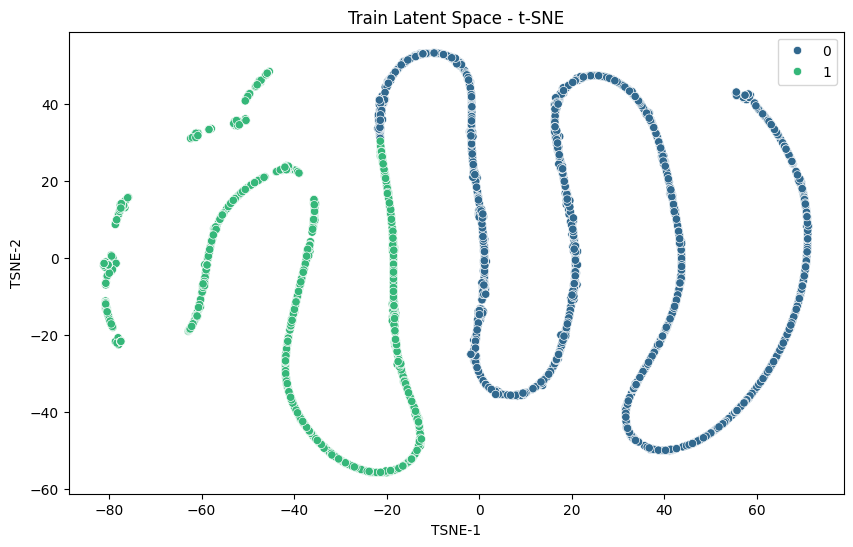

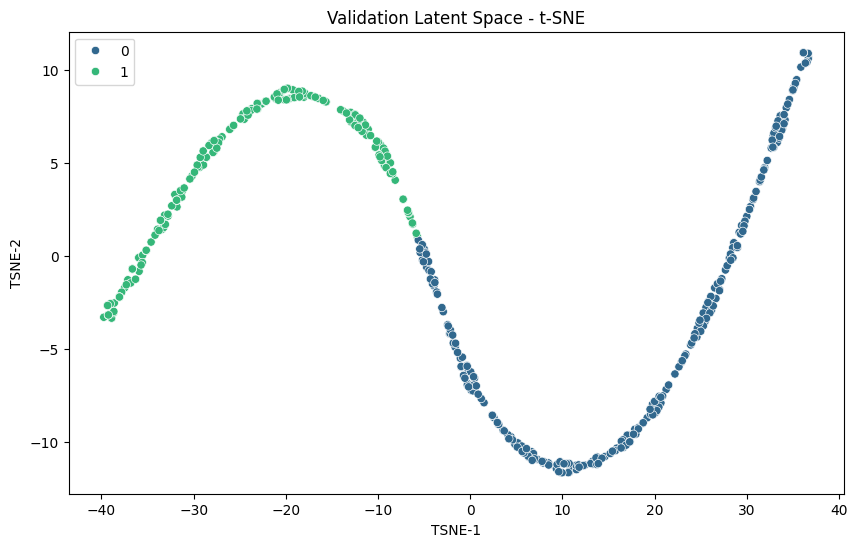


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        80
           1       0.82      1.00      0.90       374

    accuracy                           0.82       454
   macro avg       0.41      0.50      0.45       454
weighted avg       0.68      0.82      0.74       454



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


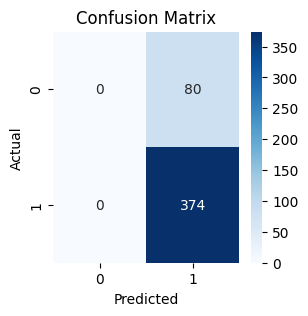

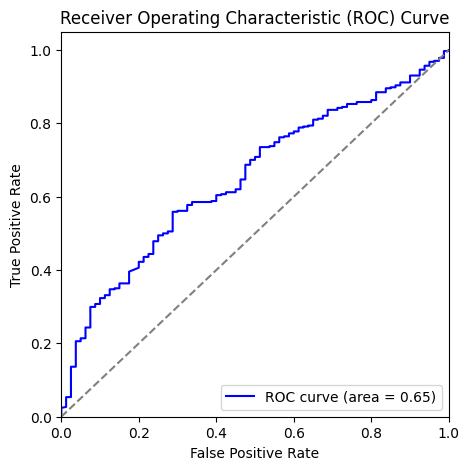


Logistic Regression Cross-Validation Scores: 0.8237885462555066

Logistic Regression Mean Cross-Validation Accuracy: 0.8237885462555066


In [ ]:
def train_unsup_dis():
    """
    Combines the unsupervised (Autoencoder) and discriminative (Logistic Regression) models
    for training and evaluation.

    This function trains a Word2Vec model to generate embeddings, then trains an Autoencoder
    to reduce the dimensionality of these embeddings. The reduced embeddings are clustered
    using K-Means, and sentiment scores are computed for each cluster using VADER sentiment
    analyzer. These clusters and sentiment scores are used to create labels for the data,
    which are then used to train a Logistic Regression model.
    """
    unsup_model_path = os.path.join(GOOGLE_DRIVE_PATH, 'model', str(student_id), 'Model_Unsup')
    dis_model_path = os.path.join(GOOGLE_DRIVE_PATH, 'model', str(student_id), 'Model_Dis')
    os.makedirs(unsup_model_path, exist_ok=True)
    os.makedirs(dis_model_path, exist_ok=True)

    # Prepare the data for Word2Vec
    train_sentences = train_df['tokens'].tolist()
    valid_sentences = valid_df['tokens'].tolist()
    all_sentences = train_sentences + valid_sentences

    # Train Word2Vec model
    word2vec_model = train_word2vec(all_sentences)

    # Get embeddings for train and validation sets
    train_embeddings = train_df['tokens'].apply(lambda x: get_embedding(x, word2vec_model))
    valid_embeddings = valid_df['tokens'].apply(lambda x: get_embedding(x, word2vec_model))

    # Convert embeddings to numpy arrays
    train_embeddings = np.array(list(train_embeddings))
    valid_embeddings = np.array(list(valid_embeddings))

    print("Shape of train embeddings:", train_embeddings.shape)
    print("Shape of valid embeddings:", valid_embeddings.shape)

    # Train Autoencoder
    autoencoder_model = train_autoencoder(train_embeddings, valid_embeddings)

    # Encode the embeddings
    with torch.no_grad():
        train_encoded = autoencoder_model.encoder(torch.tensor(train_embeddings, dtype=torch.float32)).numpy()
        valid_encoded = autoencoder_model.encoder(torch.tensor(valid_embeddings, dtype=torch.float32)).numpy()

    # Apply K-Means clustering
    kmeans_model = train_kmeans(np.vstack((train_encoded, valid_encoded)), num_clusters=2)

    # Assign clusters to train and validation sets
    train_clusters = kmeans_model.predict(train_encoded)
    valid_clusters = kmeans_model.predict(valid_encoded)

    train_df['cluster'] = train_clusters
    valid_df['cluster'] = valid_clusters

    # Initialize VADER sentiment analyzer
    analyzer = SentimentIntensityAnalyzer()

    # Get sentiment scores for each cluster
    cluster_sentiments = {cluster_id: get_cluster_sentiment(cluster_id, train_df, analyzer) for cluster_id in range(kmeans_model.n_clusters)}

    # Assign sentiment to each review based on the cluster
    train_df['predicted_sentiment'] = train_df['cluster'].map(cluster_sentiments)
    train_df['predicted_label'] = train_df['predicted_sentiment'].apply(lambda x: 1 if x >= 0 else 0)

    valid_df['predicted_sentiment'] = valid_df['cluster'].map(cluster_sentiments)
    valid_df['predicted_label'] = valid_df['predicted_sentiment'].apply(lambda x: 1 if x >= 0 else 0)

    # Ensure 'label' column is present
    sentiment_mapping = {'positive': 1, 'negative': 0}
    train_df['label'] = train_df['sentiment'].map(sentiment_mapping)
    valid_df['label'] = valid_df['sentiment'].map(sentiment_mapping)

    # Evaluate clustering performance
    silhouette_avg_train = silhouette_score(train_encoded, train_clusters)
    silhouette_avg_valid = silhouette_score(valid_encoded, valid_clusters)
    db_score_train = davies_bouldin_score(train_encoded, train_clusters)
    db_score_valid = davies_bouldin_score(valid_encoded, valid_clusters)

    print()
    print(f"Train Silhouette Score: {silhouette_avg_train}")
    print(f"Validation Silhouette Score: {silhouette_avg_valid}")
    print(f"Train Davies-Bouldin Score: {db_score_train}")
    print(f"Validation Davies-Bouldin Score: {db_score_valid}")

    # Visualize latent space using t-SNE
    print()
    plot_tsne(train_encoded, train_clusters, "Train Latent Space - t-SNE")
    print()
    plot_tsne(valid_encoded, valid_clusters, "Validation Latent Space - t-SNE")

    # Train and evaluate Logistic Regression model
    log_reg_model, log_reg_valid_scores = train_logistic_regression(train_encoded, train_df['label'], valid_encoded, valid_df['label'])

    print()
    print(f"Logistic Regression Cross-Validation Scores: {log_reg_valid_scores}")
    print()
    print(f"Logistic Regression Mean Cross-Validation Accuracy: {log_reg_valid_scores.mean()}")

    # Fit the model on the entire training set
    log_reg_model.fit(train_encoded, train_df['label'])

train_unsup_dis()